# Calibration of a End-of-Arm Camera

This exercise will describe how to calibrate a end-of-arm camera using marker-board detection.
The excercise is divided into the following steps.

1. Load recorded images.
2. Show marker detection results.
3. Solve for the calibration.
4. Analysis of results.

First lets have a look at the data.

Note: if the interactive viewer does not work you may have to restart the notebook with `%matplotlib widget` instead of `%matplotlib notebook`

Note: install jupyter in your conda environment via
`conda install -c conda-forge notebook` and the other missing packages.
Start it in the command line via jupter notebook --port xxxx. Use the vs-code pop up to open jupyter in your local server.


In [1]:
%matplotlib notebook
#%matplotlib widget
import os
import logging
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from scipy.spatial.transform import Rotation as R
try:
    import open3d as o3d
except ImportError:
    pass

log = logging.getLogger(__name__)
np.set_printoptions(suppress=True)

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
# Download the data required for this exercise (30Mb)
! wget https://lmb.informatik.uni-freiburg.de/people/argusm/marker.tar
! tar -xvf marker.tar
# Update: please find the files under `/project/cv-ws2122/shared-data1/marker`

--2022-01-26 14:48:37--  https://lmb.informatik.uni-freiburg.de/people/argusm/marker.tar
Auflösen des Hostnamens lmb.informatik.uni-freiburg.de (lmb.informatik.uni-freiburg.de) … 132.230.167.23
Verbindungsaufbau zu lmb.informatik.uni-freiburg.de (lmb.informatik.uni-freiburg.de)|132.230.167.23|:443 … verbunden.
HTTP-Anforderung gesendet, auf Antwort wird gewartet … 200 OK
Länge: 30074880 (29M) [application/x-tar]
Wird in »marker.tar.1« gespeichert.

marker.tar.1        100%[===================>]  28,68M  6,06MB/s    in 4,8s    

2022-01-26 14:48:42 (6,00 MB/s) - »marker.tar.1« gespeichert [30074880/30074880]

marker/depth_0000.png
marker/depth_0001.png
marker/depth_0002.png
marker/depth_0003.png
marker/depth_0004.png
marker/depth_0005.png
marker/depth_0006.png
marker/depth_0007.png
marker/depth_0008.png
marker/depth_0009.png
marker/depth_0010.png
marker/depth_0011.png
marker/depth_0012.png
marker/depth_0013.png
marker/depth_0014.png
marker/depth_0015.png
marker/depth_0016.png
marker/dep

# 1. Load Recorded Images

This cell defines a data class that loads images and data from files.

Please complete the `get_projection_matrix` function.

In [2]:
import json
from PIL import Image

class ViewLoader:
    def __init__(self, base_path):
        self.base_path = base_path
        assert os.path.isdir(base_path)
        files = sorted(os.listdir(self.base_path))
        files = [f for f in files if (f.startswith("rgb_") and f.endswith(".png"))]
        self.max_idx = int(files[-1].replace("rgb_", "").replace(".png", ""))
        print(f"Loaded {self.max_idx+1} images.")
        
    def __len__(self):
        return self.max_idx + 1
    
    def __getitem__(self, idx):
        return self.get_rgbdp(idx)

    def get_info(self):
        info_path = os.path.join(self.base_path, 'info.json')
        with open(info_path, "rb") as f_obj:
            info  = json.load(f_obj)
        return info
    
    def get_intrinsics(self):
        info = self.get_info()
        calib = info["camera"]["calibration"]
        return calib
    
    def get_K(self):
        calib = self.get_intrinsics()
        cam_intrinsic = np.eye(3)
        cam_intrinsic[0, 0] = calib["fx"]
        cam_intrinsic[1, 1] = calib["fy"]
        cam_intrinsic[0, 2] = calib["ppx"]
        cam_intrinsic[1, 2] = calib["ppy"]
        return cam_intrinsic
    
    def get_robot_pose(self, idx, return_dict=False):
        pose_file = os.path.join(self.base_path, "pose_{0:04d}.json".format(idx) )
        with open(pose_file,"rb") as f_obj:
            pose = json.load(f_obj)
        pose_m = np.eye(4)
        pose_m[:3, :3] = R.from_euler("xyz", [pose[x] for x in ['rot_x', 'rot_y', 'rot_z']]).as_matrix()
        pose_m[:3, 3] = [pose[x] for x in ['x', 'y', 'z']]
        if return_dict:
            return pose_m, pose
        else:
            return pose_m
    
    def get_rgb_file(self, idx):
        rgb_file = os.path.join(self.base_path, "rgb_{0:04d}.png".format(idx) )
        return rgb_file
    
    def get_depth_file(self, idx):
        depth_file = os.path.join(self.base_path, "depth_{0:04d}.png".format(idx) )
        return depth_file    
    
    def get_rgbdp(self, idx):
        rgb_file = self.get_rgb_file(idx)
        depth_file = self.get_depth_file(idx)
        
        pose_m, pose_d = self.get_robot_pose(idx, True)
        # depth
        depth_scaling = pose_d["depth_scaling"]
        rgb  = np.asarray(Image.open(rgb_file))
        depth = np.asarray(Image.open(depth_file), dtype=np.float32) * depth_scaling
        return rgb, depth, pose_m
        
    def get_cam_pose(self, idx, marker_dir="pose_marker_one"):
        marker_dir = os.path.join(self.base_path, marker_dir)
        fn  = "{0:08d}.json".format(idx)
        pose_fn = os.path.join(marker_dir, fn)
        with open(pose_fn, "r") as fo:
            T = np.array(json.load(fo))
        return T
    
    def get_projection_matrix(self):
        # returns a 4x3 projection matrix using the intrinsics
        # TODO
        cam_mat = np.zeros((3, 4))
        cam_mat[:, :-1] = self.get_K()
        # end todo
        assert cam_mat.shape == (3, 4)
        return cam_mat
    

    def project(self, X):
        """
        Project an (homogenous) cartesian coordinate into the camera frame.
        """
        if X.shape[0] == 3:
            if len(X.shape) == 1:
                X = np.append(X, 1)
            else:
                X = np.concatenate([X, np.ones((1, X.shape[1]))], axis=0)

        x = self.get_projection_matrix() @ X
        result = np.round(x[0:2] / x[2]).astype(int)
        width, height = self.get_intrinsics()['width'], self.get_intrinsics()['height']
        if not (0 <= result[0] < width and 0 <= result[1] < height):
            log.warning("Projected point outside of image bounds")
        return result[0], result[1]

vl = ViewLoader(base_path="marker")
print("camera calibration:")
camera_calibration = vl.get_K()
K = np.array(camera_calibration)
print(K.round(2))

Loaded 50 images.
camera calibration:
[[616.2    0.   311.53]
 [  0.   616.2  235.69]
 [  0.     0.     1.  ]]


<IPython.core.display.Javascript object>


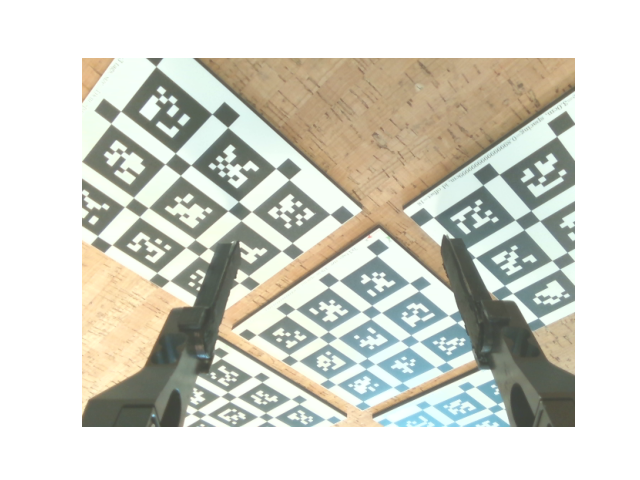

interactive(children=(IntSlider(value=0, description='w', layout=Layout(width='70%'), max=49), Output()), _dom…

<function __main__.update(w)>

In [3]:
from ipywidgets import widgets, Layout, interact

fig, ax = plt.subplots(1)
image, depth, pose = vl.get_rgbdp(0)
line = ax.imshow(np.asarray(image))
ax.set_axis_off()

def update(w):
    image, depth, pose = vl.get_rgbdp(w)
    line.set_data(np.asarray(image))
    fig.canvas.draw_idle()
    
slider_w = widgets.IntSlider(min=0, max=len(vl)-1, step=1, value=0,
                             layout=Layout(width='70%'))
interact(update, w=slider_w)

# 2. Show Marker Detection Results.

To simplify things marker detection has already been run. Next we want to verify its results.
Do this by completing the `get_projection_matrix` function in the ViewLoader.
Then draw a coordinate frame into each image for which we have detection results.
The coordinate frame should have axis lengths of 10cm, with x=red, y=green, and z=blue.
This can be done using `PIL.ImageDraw`.

<IPython.core.display.Javascript object>


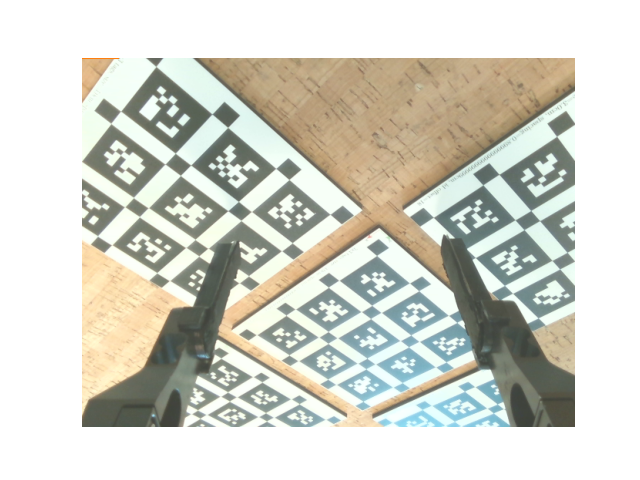

Center (203, 317)


interactive(children=(IntSlider(value=0, description='w', layout=Layout(width='70%'), max=49), Output()), _dom…

<function __main__.update(w)>

In [19]:
from PIL import ImageDraw

def show_marker_pose(image, T_cam_object):
    """
    draw the coordinate frame into each image for which we have detection results
    Arguments:
        image: image as numpy.ndarray
        T_cam_object: transform from object into cam x_cam = T_cam_object @ x
    Returns:
        im: image (should be PIL.Image.Image)
    """
    # TODO
    #  using PIL.ImageDraw
    center = np.array([0, 0, 0, 1])
    x = np.array([0.1, 0, 0, 1])
    y = np.array([0, 0.1, 0, 1])
    z = np.array([0, 0, 0.1, 1])
    
    center_cam = T_cam_object @ center
    x_cam = T_cam_object @ x
    y_cam = T_cam_object @ y
    z_cam = T_cam_object @ z
    
    center_img = vl.project(center_cam)
    x_img = vl.project(x_cam)
    y_img = vl.project(y_cam)
    z_img = vl.project(z_cam)
    print("Center", center_img)

    im = Image.fromarray(image.astype('uint8'), 'RGB')
    draw = ImageDraw.Draw(im)
    draw.line([center_img, x_img], fill=(255, 0, 0, 255))
    draw.line([center_img, y_img], fill=(0, 255, 0, 255))
    draw.line([center_img, z_img], fill=(0, 0, 255, 255))

    # end TODO
    return im

image, depth, robot_pose = vl.get_rgbdp(1)
T_cam_object = vl.get_cam_pose(1)

fig, ax = plt.subplots(1)
image_m = show_marker_pose(image, T_cam_object)
line = ax.imshow(np.asarray(image_m))
ax.set_axis_off()

def update(w):
    image, depth, pose = vl.get_rgbdp(w)
    try:
        T_cam_object = vl.get_cam_pose(w)
    except FileNotFoundError:
        print("No pose estimation.")
        line.set_data(np.asarray(image))
        return
    image_m = show_marker_pose(image, T_cam_object)
    line.set_data(np.asarray(image_m))
    fig.canvas.draw_idle()
    
slider_w = widgets.IntSlider(min=0, max=len(vl)-1, step=1, value=0,
                             layout=Layout(width='70%'))
interact(update, w=slider_w)

In [20]:
def get_tcp_marker_lists(m_dir="pose_marker_one"):
    T_robot_tcp_list = []
    T_cam_marker_list = []
    for i in range(len(vl)):
        try:
            robot_pose = vl.get_robot_pose(i)
            cam_pose = vl.get_cam_pose(i, marker_dir=m_dir)
        except (FileNotFoundError, ValueError):
            continue
        T_robot_tcp_list.append(robot_pose)
        T_cam_marker_list.append(cam_pose)

    return np.array(T_robot_tcp_list), np.array(T_cam_marker_list)

#plot_o3d = True
plot_o3d = False
if plot_o3d:
    T_robot_tcp_list, T_cam_marker_list = get_tcp_marker_lists()
    mesh_frames = []
    for T_robot_tcp, T_cam_marker in zip(T_robot_tcp_list, T_cam_marker_list):
        mesh_frame = o3d.geometry.TriangleMesh.create_coordinate_frame(size=0.1)
        mesh_frame.transform(np.linalg.inv(T_robot_tcp))
        mesh_frames.append(mesh_frame)
        
        mesh_frame = o3d.geometry.TriangleMesh.create_coordinate_frame(size=0.20)
        mesh_frame.transform(T_cam_marker)
        mesh_frames.append(mesh_frame)

    o3d.visualization.draw_geometries(mesh_frames)

# 3. Solve for the Calibration

We will try to find the calibration using two different methods, via least squares optimization and using the park martin algorithm.

In [21]:
def vec_to_matrix(x):
    mat = np.eye(4)
    mat[:3, 3] = x[0:3]
    mat[:3, :3] = R.from_euler('xyz', x[3:6]).as_matrix()
    return mat

def pprint(arr):
    return np.array2string(arr.round(5), separator=', ')

def matrix_to_pos_orn(mat): 
    """
    :param mat: 4x4 homogeneous transformation
    :return: tuple(position: np.array of shape (3,), orientation: np.array of shape (4,) -> quaternion xyzw)
    """
    orn = R.from_matrix(mat[:3, :3]).as_quat()
    pos = mat[:3, 3]
    return pos, orn

def calculate_error(T_tcp_cam, T_robot_tcp_list, T_cam_marker_list, inliers=None):
    """
    returns scalar error for each entry
    """
    T_robot_marker_list = []
    for T_robot_tcp, T_cam_marker in zip(T_robot_tcp_list, T_cam_marker_list):
        T_robot_marker = T_robot_tcp @ T_tcp_cam @ T_cam_marker
        T_robot_marker_list.append(T_robot_marker)
    
    poses = np.array(T_robot_marker_list)[:, :3, 3]
    if inliers is None:
        mean_pose = np.mean(poses, axis=0)
    else:
        mean_pose = np.mean(poses[inliers], axis=0)
    err = np.sum((poses - mean_pose)**2, axis=1)
    return err

def pose_error(T_tcp_cam, T_robot_tcp_list, T_cam_marker_list):
    """
    returns position tuple for each entry
    
    Arguments:
        T_tcp_cam: cam to tcp transform
        T_robot_tcp_list: robot base <- tcp transforms, shape (N, 4, 4 )
        T_cam_marker_list: cam <- marker transforms, shape (N, 4, 4)
    Returns:
        error: cartesian error (N, 3)
    """
    T_robot_marker_list = []
    for T_robot_tcp, T_cam_marker in zip(T_robot_tcp_list, T_cam_marker_list):
        T_robot_marker = T_robot_tcp @ T_tcp_cam @ T_cam_marker
        T_robot_marker_list.append(T_robot_marker)
    
    poses = np.array(T_robot_marker_list)[:, :3, 3]
    err = poses - np.mean(poses, axis=0)
    return err

# Least-Squares Optimization

We know that `T_robot_marker` and `T_cam_tcp` are fixed, so these can be used as variables that have to be optimized.
From these values compute the predicted `T_cam_marker_pred` and compare it to `T_cam_marker_obs`.
We can do the comparison based only on position values, so `T_robot_marker` only uses position components.
Optimize the function using `scipy.optimize.least_squares`.

`T_cam_marker = T_cam_tcp @ T_tcp_robot @ T_robot_marker`

In [27]:
from scipy.optimize import least_squares, minimize

def compute_residuals_gripper_cam(x, T_robot_tcp_list, T_cam_marker_list):
    # calculate predicted values using T_cam_tcp and T_robot_marker
    # use these predicted values along with the observes values to calculate and returns the residuals
    T_robot_marker = np.array([*x[6:], 1])
    T_cam_tcp = vec_to_matrix(x)
    
    # TODO
    residuals = []
    for T_robot_tcp_obs, T_cam_marker_obs in zip(T_robot_tcp_list, T_cam_marker_list):
        T_tcp_robot_obs = np.linalg.inv(T_robot_tcp_obs)
        T_cam_marker_pred = T_cam_tcp @ T_tcp_robot_obs @ T_robot_marker
        cam_marker_pred_pos = T_cam_marker_pred[:3] / T_cam_marker_pred[3]
        cam_marker_obs_pos, _ = matrix_to_pos_orn(T_cam_marker_obs)
        residuals += list(cam_marker_pred_pos - cam_marker_obs_pos)
    
    assert len(residuals) == 144  # 144= 48 samples * 3 x,y,z
    return residuals

def calibrate_gripper_cam_ls(T_robot_tcp_list, T_cam_marker_list):
    # use scipy least squares to optimize the above function and return the calibration
    # todo
    x0 = np.array([0, 0, 0, 0, 0, 0, 0, 0, -0.1])
    result = least_squares(fun=compute_residuals_gripper_cam, x0=x0, method='lm',
                           args=(T_robot_tcp_list, T_cam_marker_list))
    T_calib = np.linalg.inv(vec_to_matrix(result.x))
    
    # end todo
    assert T_calib.shape == (4, 4)
    return T_calib

T_robot_tcp_list, T_cam_marker_list = get_tcp_marker_lists()
T_calib = calibrate_gripper_cam_ls(T_robot_tcp_list, T_cam_marker_list)
err_ls = pose_error(T_calib, T_robot_tcp_list, T_cam_marker_list)
err_ls_s = np.sum(err_ls**2, axis=1)
print("median error ls", np.median(err_ls_s))

median error ls 7.868468766545211e-07


In [28]:
# Try to slighlty improve the result using differential evolution
# nothing required here.

import scipy
def calibrate_gripper_cam_de(T_robot_tcp_list, T_cam_marker_list):
    x0 = np.array([0, 0, 0, 0, 0, 0, 0, 0, -0.1])
    result = least_squares(fun=compute_residuals_gripper_cam, x0=x0, method='lm',
                           args=(T_robot_tcp_list, T_cam_marker_list))
    T_calib = np.linalg.inv(vec_to_matrix(result.x))
    
    x0 = result.x
    bounds = [(x-.0001, x+.0001) for x in x0]
    def func(x, *args):
        T_cam_tcp = vec_to_matrix(x)
        return calculate_error(T_cam_tcp, *args).mean()
    result2 = scipy.optimize.differential_evolution(func=func, bounds=bounds,
                           args=(T_robot_tcp_list, T_cam_marker_list), tol=1e-11)
    T_calib = np.linalg.inv(vec_to_matrix(result2.x))
    #print(result.x)
    #print(bounds)
    return T_calib

T_calib = calibrate_gripper_cam_de(T_robot_tcp_list, T_cam_marker_list)
err_ls = pose_error(T_calib, T_robot_tcp_list, T_cam_marker_list)
err_ls_s = np.sum(err_ls**2, axis=1)
print("median error ls", np.median(err_ls_s))

median error ls 7.746898790766487e-07


# Park-Martin Calibration

Have a look here for the description of the Park-Martin method.

https://www.torsteinmyhre.name/snippets/robcam_calibration.html

We are trying to solve the following equation: `AX = XB`. Follow the instructions on the website to create the lists `As`,`Bs`.


In [29]:
import itertools
def log_func(R):
    # Rotation matrix logarithm
    theta = np.arccos((R[0,0] + R[1,1] + R[2,2] - 1.0)/2.0)
    return np.array([R[2,1] - R[1,2], R[0,2] - R[2,0], R[1,0] - R[0,1]]) * theta / (2*np.sin(theta))

def invsqrt(mat):
    u,s,v = np.linalg.svd(mat)
    return u.dot(np.diag(1.0/np.sqrt(s))).dot(v)

def calibrate(A, B):
    #transform pairs A_i, B_i
    N = len(A)
    M = np.zeros((3, 3))
    for i in range(N):
        Ra, Rb = A[i][0:3, 0:3], B[i][0:3, 0:3]
        M += np.outer(log_func(Rb), log_func(Ra))

    Rx = np.dot(invsqrt(np.dot(M.T, M)), M.T)

    C = np.zeros((3*N, 3))
    d = np.zeros((3*N, 1))
    for i in range(N):
        Ra, ta = A[i][0:3, 0:3], A[i][0:3, 3]
        Rb, tb = B[i][0:3, 0:3], B[i][0:3, 3]
        C[3*i:3*i+3, :] = np.eye(3) - Ra
        d[3*i:3*i+3, 0] = ta - np.dot(Rx, tb)

    tx = np.dot(np.linalg.inv(np.dot(C.T, C)), np.dot(C.T, d))    
    X = np.eye(4)
    X[:3, :3] = Rx
    X[:3, 3] = tx.flatten()
    return X

def calibrate_gripper_cam_peak_martin(T_robot_tcp_list, T_cam_marker_list):
    ECs = []
    for T_robot_tcp, t_cam_marker in zip(T_robot_tcp_list, T_cam_marker_list):
        T_tcp_robot = np.linalg.inv(T_robot_tcp)
        ECs.append((T_tcp_robot, t_cam_marker))

    As = []  # relative EEs
    Bs = []  # relative cams
    for pair in itertools.combinations(ECs, 2):
        (e_1, c_1), (e_2, c_2) = pair
        A = e_2 @ np.linalg.inv(e_1)
        B = c_2 @ np.linalg.inv(c_1)
        As.append(A)
        Bs.append(B)

        # symmetrize
        A = e_1 @ np.linalg.inv(e_2)
        B = c_1 @ np.linalg.inv(c_2)
        As.append(A)
        Bs.append(B)
    
    X = calibrate(As, Bs)
    return X

# 4. Analysis of results

Lets have a look at the results of both methods. 

1. How much does each datapoint contribute to the overall error? How much does each cartesian dimension contribute to the overall error?
2. Does the error correlate with distance from the camera?
3. How do the results change if we remove high error datapoints?

<IPython.core.display.Javascript object>


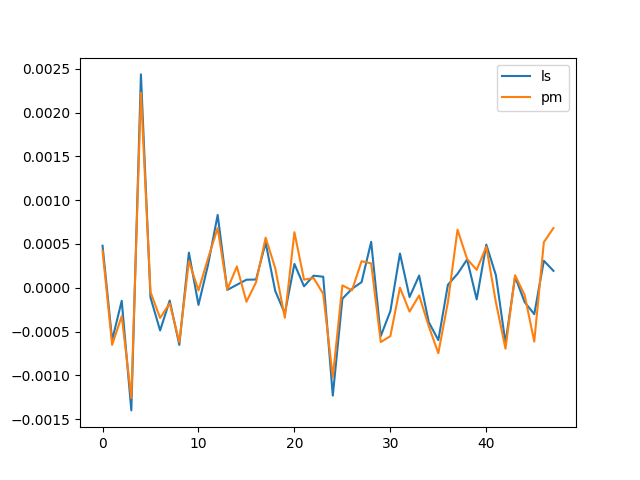

In [43]:
T_robot_tcp_list, T_cam_marker_list = get_tcp_marker_lists()
T_calib = calibrate_gripper_cam_ls(T_robot_tcp_list, T_cam_marker_list)
err_ls = pose_error(T_calib, T_robot_tcp_list, T_cam_marker_list) # (48, 3)

T_calib = calibrate_gripper_cam_peak_martin(T_robot_tcp_list, T_cam_marker_list)
err_pm = pose_error(T_calib, T_robot_tcp_list, T_cam_marker_list) # (48, 3)

#TODO make plots here.
datapoint_err_ls = np.mean(err_ls, axis=1)
datapoint_err_pm = np.mean(err_pm, axis=1)
plt.plot(datapoint_err_ls, label="ls")
plt.plot(datapoint_err_pm, label="pm")
plt.legend()
plt.show()

<IPython.core.display.Javascript object>


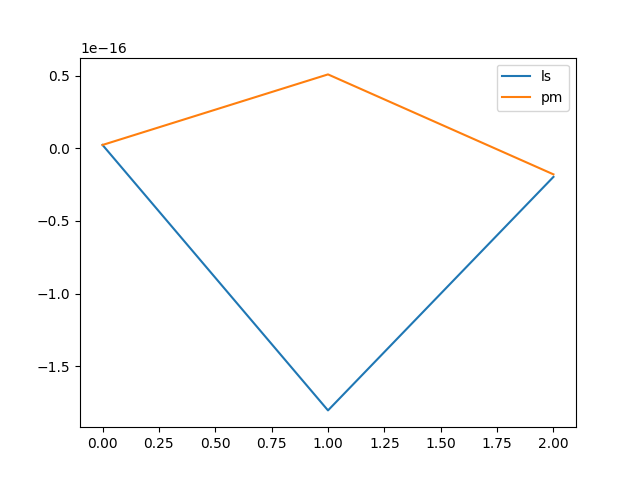

In [44]:
dim_err_ls = np.mean(err_ls, axis=0)
dim_err_pm = np.mean(err_pm, axis=0)
plt.plot(dim_err_ls, label="ls")
plt.plot(dim_err_pm, label="pm")
plt.legend()
plt.show()

## Error-Depth Correlation

Does the error correlate with distance from the camera?


<IPython.core.display.Javascript object>


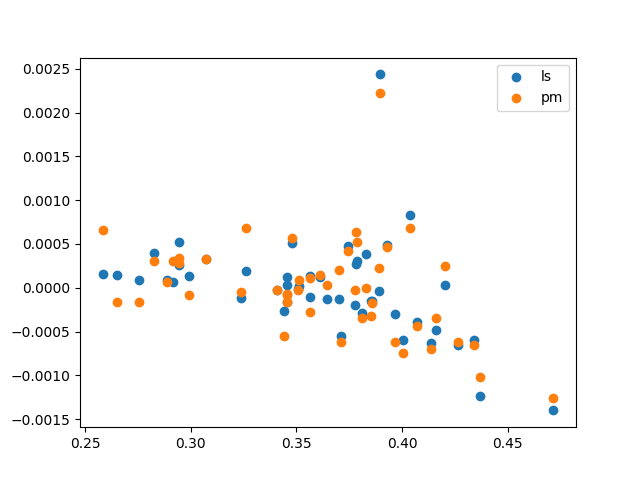

In [50]:
# TODO: Make plots here
distances = []
for T_cam_marker_obs in T_cam_marker_list:
    cam_marker_obs_pos, _ = matrix_to_pos_orn(T_cam_marker_obs)
    distances.append(np.linalg.norm(cam_marker_obs_pos))
distances = np.array(distances)
plt.scatter(distances, datapoint_err_ls, label="ls")
plt.scatter(distances, datapoint_err_pm, label="pm")
plt.legend()
plt.show()

## 4.3 Remove High-Error Samples.

How do the results change if we remove high error datapoints?

In [ ]:
# TODO: Make plots here


# Exercise Complete

The addtional material is provided as a quick introduction into Open3D. There is nothing to do there, run the code if you have time.

In [51]:
# Finally lets plot errors as a funciton of T_robot_tcp positions
# This can be done using the open3d create_coordinate_frame command.
mesh_frames = []
err_ls = pose_error(T_calib, T_robot_tcp_list, T_cam_marker_list)
err_ls_s = np.sum(err_ls**2, axis=1)
err_ls_sn = err_ls_s / np.sum(err_ls_s)
for T_robot_tcp, err in zip(T_robot_tcp_list, err_ls_sn):    
    mesh_frame = o3d.geometry.TriangleMesh.create_coordinate_frame(size=0.05+err)
    mesh_frame.transform(T_robot_tcp)
    mesh_frames.append(mesh_frame)
o3d.visualization.draw_geometries(mesh_frames)

[Open3D WARNING] GLFW Error: X11: The DISPLAY environment variable is missing
[Open3D WARNING] Failed to initialize GLFW
[Open3D WARNING] [DrawGeometries] Failed creating OpenGL window.


# Display Merged Pointclouds

In [52]:
import open3d as o3d

first_rgb = Image.open(vl.get_rgb_file(1))
K_o3d = o3d.camera.PinholeCameraIntrinsic()
K_o3d.set_intrinsics(first_rgb.size[1], first_rgb.size[0],
                     K[0, 0], K[1, 1], K[0, 2], K[1, 2])

pcd_list = []
for i in range(len(vl)):
    try:
        rgb_file = Image.open(vl.get_rgb_file(i))
        depth_file = Image.open(vl.get_depth_file(i))
        T_c = vl.get_cam_pose(i)
        T_r = vl.get_robot_pose(i)
        depth_scaling = vl.get_robot_pose(i, return_dict=True)[1]["depth_scaling"]
    except (FileNotFoundError, ValueError):
        continue
    
    rgb = o3d.geometry.Image(np.array(rgb_file))
    depth = o3d.geometry.Image(np.array(depth_file).astype(np.uint16))
    rgbd = o3d.geometry.RGBDImage.create_from_color_and_depth(rgb, depth,
                                          depth_scale=1.0/depth_scaling, depth_trunc=1.0,
                                          convert_rgb_to_intensity=False)
    pcd = o3d.geometry.PointCloud.create_from_rgbd_image(rgbd, K_o3d)
    
    #T_est = T_r @ T_calib
    T_est = np.linalg.inv(T_c)
    pcd.transform(T_est)
    pcd_list.append(pcd)

# sum pointclouds for easier visualization
pcd_all = pcd_list[0]
for pcd_cur in pcd_list[1:]:
    pcd_all += pcd_cur
o3d.visualization.draw_geometries([pcd_all])

[Open3D WARNING] GLFW Error: X11: The DISPLAY environment variable is missing
[Open3D WARNING] Failed to initialize GLFW
[Open3D WARNING] [DrawGeometries] Failed creating OpenGL window.
